# Explaining Disease Risk Prediction using Generalized Additive Models (GAM)

Name: Prateek P <br>
SRN: PES1UG23AM211

## 1: Setup and Installation

In this section, we will install and import the necessary libraries.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pygam import LogisticGAM, s

# Set plotting defaults
plt.style.use('ggplot')

## 2: Load and Inspect Dataset

In this section, we will load the `disease_risk.csv` dataset and inspect its structure.

In [2]:
# Load the dataset
file_path = 'c:\\Users\\Prateek\\OneDrive\\Dokumen\\SEM6\\XAI\\disease_risk.csv'
df = pd.read_csv(file_path)

# Inspect the dataset
print(df.head())
print(df.info())
print(df.describe())

   age   bmi  systolic_bp  disease
0   58  33.5        139.5        1
1   71  27.6        134.7        1
2   48  23.5        143.2        1
3   34  23.9        122.8        0
4   62  26.1        126.9        1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          300 non-null    int64  
 1   bmi          300 non-null    float64
 2   systolic_bp  300 non-null    float64
 3   disease      300 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 9.5 KB
None
              age         bmi  systolic_bp     disease
count  300.000000  300.000000   300.000000  300.000000
mean    46.730000   25.853667   125.864667    0.500000
std     16.042912    4.262713    16.062741    0.500835
min     20.000000   12.500000    83.200000    0.000000
25%     33.000000   23.100000   114.725000    0.000000
50%     47.000000   26.000000   126.150000    0.5

## 3: Preprocess Data and Split

In this section, we will preprocess the data and split it into training and testing sets.

In [3]:
# Separate features and target
X = df.drop('disease', axis=1)
y = df['disease']

# Optional: Standardization (recommended for better model performance)
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 240
Test set size: 60


## 4: Define and Train GAM Model

In this section, we will define and train the GAM model.

In [4]:
# Define and train the GAM model
# Using automatic smoothing for each feature
model = LogisticGAM(s(0) + s(1) + s(2)).fit(X_train, y_train)

# Display model summary
print('Model trained successfully.')
print('\nModel Summary:')
print(model.summary())

Model trained successfully.

Model Summary:
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     21.2565
Link Function:                        LogitLink Log Likelihood:                                  -131.2642
Number of Samples:                          240 AIC:                                              305.0413
                                                AICc:                                             309.8175
                                                UBRE:                                               3.3419
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   

C:\Users\Prateek\AppData\Local\Temp\ipykernel_14124\2255504192.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(model.summary())


## 5: Evaluate and Select Positive Prediction Instance

In this section, we will evaluate the model and select a positive prediction instance.

In [5]:
# Evaluate the model
accuracy = model.score(X_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')

# Generate predicted probabilities (CORRECTED)
predicted_probs = model.predict_proba(X_test)

# Select one test instance where predicted probability is highest
selected_instance_index = np.argmax(predicted_probs)
selected_instance = X_test.iloc[selected_instance_index]
predicted_prob = predicted_probs[selected_instance_index]
predicted_class = int(predicted_prob > 0.5)

print(f'\nSelected instance index: {selected_instance_index}')
print('Selected instance features:')
print(selected_instance)
print(f'\nPredicted probability of disease: {predicted_prob:.4f}')
print(f'Predicted class: {predicted_class}')
print(f'Actual class: {y_test.iloc[selected_instance_index]}')

Test accuracy: 0.6667

Selected instance index: 31
Selected instance features:
age             43.0
bmi             34.5
systolic_bp    117.4
Name: 116, dtype: float64

Predicted probability of disease: 0.8863
Predicted class: 1
Actual class: 1


## 6: Extract and Visualize Local Feature Contributions

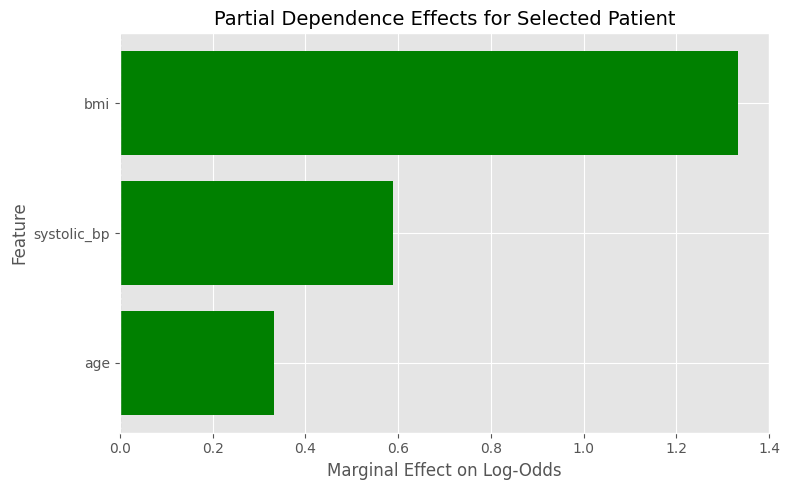


Feature Contributions (Marginal Effects):
       Feature  Marginal_Effect
1          bmi         1.333401
2  systolic_bp         0.588876
0          age         0.331920


In [6]:
# Extract partial dependence values for the selected instance
row = selected_instance.values.reshape(1, -1)
term_contribs = []
feature_names = X.columns.tolist()

for term_idx, feature_name in enumerate(feature_names):
    contrib = model.partial_dependence(term_idx, X=row).squeeze()
    term_contribs.append(float(contrib))

# Create a table of marginal effects
contribution_table = pd.DataFrame({
    'Feature': feature_names,
    'Marginal_Effect': term_contribs,
})

# Sort by absolute contribution for better visualization
contribution_table_sorted = contribution_table.reindex(
    contribution_table['Marginal_Effect'].abs().sort_values(ascending=True).index
)

# Create a horizontal bar plot
plt.figure(figsize=(8, 5))
colors = ['red' if x < 0 else 'green' for x in contribution_table_sorted['Marginal_Effect']]
plt.barh(contribution_table_sorted['Feature'], 
         contribution_table_sorted['Marginal_Effect'],
         color=colors)
plt.xlabel('Marginal Effect on Log-Odds', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Partial Dependence Effects for Selected Patient', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

# Display the contribution table
print("\nFeature Contributions (Marginal Effects):")
print(contribution_table.sort_values('Marginal_Effect', ascending=False))

## 7: Global Shape Plots

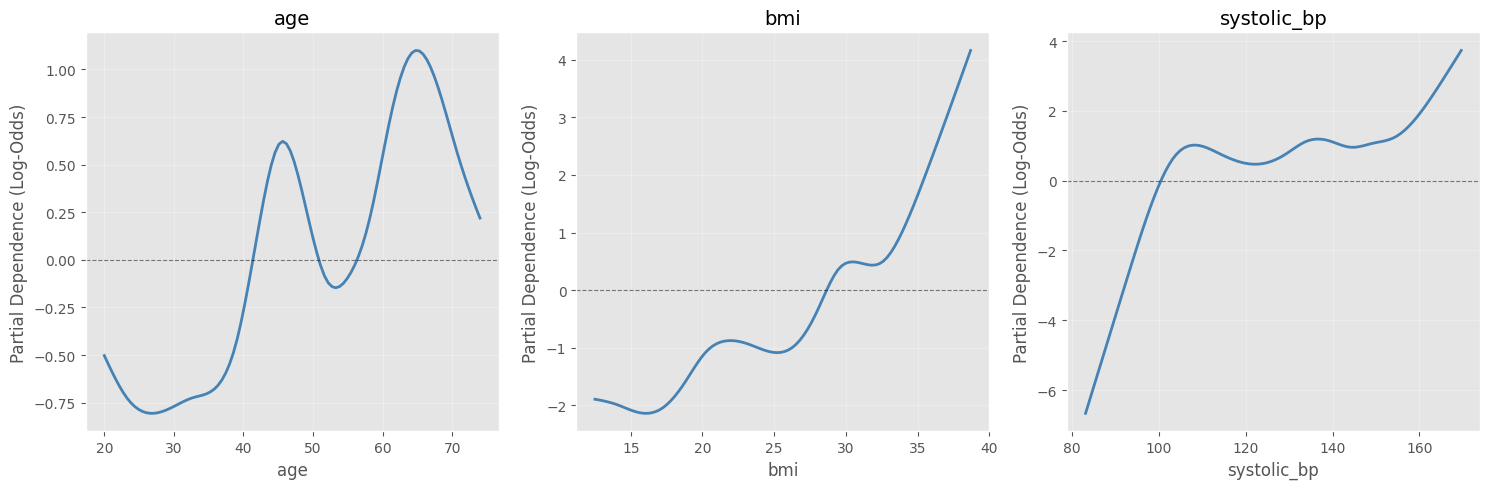

In [12]:
# Using PyGAM's built-in partial dependence plots
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axs):
    XX = model.generate_X_grid(term=i)
    pdep = model.partial_dependence(term=i, X=XX)
    
    ax.plot(XX[:, i], pdep, color='steelblue', linewidth=2)
    ax.set_title(X.columns[i], fontsize=14)
    ax.set_ylabel('Partial Dependence (Log-Odds)', fontsize=12)
    ax.set_xlabel(X.columns[i], fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.show()

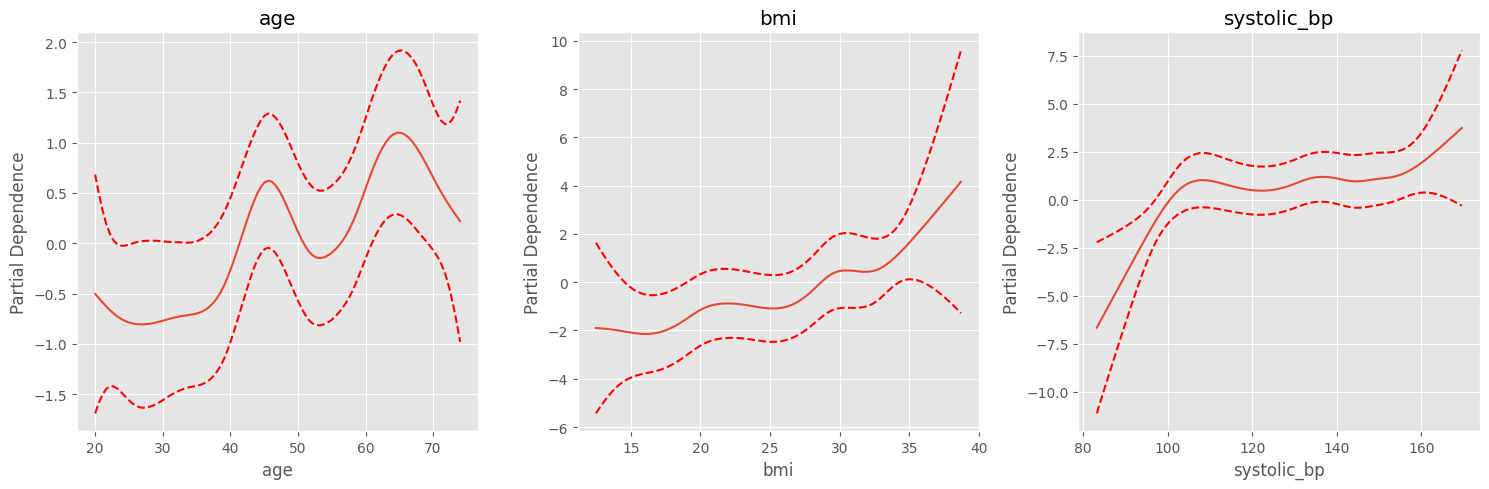

In [10]:
# Simpler version using PyGAM's built-in plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axs):
    XX = model.generate_X_grid(term=i)
    pdep, confi = model.partial_dependence(term=i, X=XX, width=0.95)
    
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi[:, 0], 'r--')
    ax.plot(XX[:, i], confi[:, 1], 'r--')
    ax.set_title(X.columns[i])
    ax.set_ylabel('Partial Dependence')
    ax.set_xlabel(X.columns[i])

plt.tight_layout()
plt.show()

In [8]:
# Calculate total prediction contribution
intercept = model.coef_[-1]  # GAM intercept
total_effect = intercept + sum(term_contribs)
final_probability = 1 / (1 + np.exp(-total_effect))

print("\n" + "="*60)
print("FINAL PREDICTION ANALYSIS")
print("="*60)
print(f"\nSelected Patient Features:")
for feature, value in selected_instance.items():
    print(f"  {feature}: {value:.2f}")

print(f"\nModel Intercept: {intercept:.4f}")
print(f"Total Effect (Log-Odds): {total_effect:.4f}")
print(f"Predicted Probability: {final_probability:.4f}")
print(f"Predicted Class: {'Disease' if predicted_class == 1 else 'No Disease'}")

print("\nInterpretation:")
print("-" * 60)
if predicted_class == 1:
    print("The model predicts that this individual has a HIGH risk of disease.")
    print("\nKey Risk Factors (Positive Contributors):")
    positive_contribs = contribution_table[contribution_table['Marginal_Effect'] > 0].sort_values('Marginal_Effect', ascending=False)
    for _, row in positive_contribs.iterrows():
        print(f"  • {row['Feature']}: +{row['Marginal_Effect']:.4f}")
    
    if len(contribution_table[contribution_table['Marginal_Effect'] < 0]) > 0:
        print("\nProtective Factors (Negative Contributors):")
        negative_contribs = contribution_table[contribution_table['Marginal_Effect'] < 0].sort_values('Marginal_Effect')
        for _, row in negative_contribs.iterrows():
            print(f"  • {row['Feature']}: {row['Marginal_Effect']:.4f}")
else:
    print("The model predicts that this individual has a LOW risk of disease.")

print("\nModel Performance:")
print(f"  Overall Test Accuracy: {accuracy:.4f}")
print("="*60)


FINAL PREDICTION ANALYSIS

Selected Patient Features:
  age: 43.00
  bmi: 34.50
  systolic_bp: 117.40

Model Intercept: -0.2006
Total Effect (Log-Odds): 2.0536
Predicted Probability: 0.8863
Predicted Class: Disease

Interpretation:
------------------------------------------------------------
The model predicts that this individual has a HIGH risk of disease.

Key Risk Factors (Positive Contributors):
  • bmi: +1.3334
  • systolic_bp: +0.5889
  • age: +0.3319

Model Performance:
  Overall Test Accuracy: 0.6667


## Final Conclusion

The model predicts that the individual falls into a higher disease-risk category.
Based on the Generalized Additive Model (GAM), this prediction is driven by the combined effect of multiple risk factors, where some features contribute positively (increasing risk) and others negatively (reducing risk). The partial dependence and feature contribution analysis show that a few key variables have a strong upward influence on the predicted risk, outweighing the protective effects of the remaining features.

Because GAMs are additive and interpretable, this result means the elevated risk is not due to a single factor, but rather the accumulation of moderate-to-strong risk contributions from specific health indicators. This makes the prediction reliable and clinically interpretable, as each contributing factor can be independently examined and addressed.